# Introduction

In this article I want to share with you results of my analysis that I perform on the Boston Airbnb open dataset. The dataset is provided by kaggle.com and recommended by Udacity during the Nanodegree Data Scientist course.

The following Airbnb activity is included in this Boston dataset:

- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

Throughout the analysis I want to follow CRISP-DM process, actually with a few modifications. The original CRISP-DM process:
* business understanding
* data understanding
* data preparation
* data modeling
* results
* deployment

Here, I do not perform modeling as I do statistical analysis and do not train any machine learning model. I also do not deploy the results but present them in the article.

To understand the domain, I had a brief look at the data. I was thinking what would be interesting to know, from my perspective, if I would like to start renting my apartment. I came with the following questions that I want to get answered after my analysis of the data:

* What is the price distribution for each room type?
* How is the price changing over time (count in months) and what are the top 5 average most expensive zipcodes all time?
* What is the distribution of demand over the entire time, per month?


Let's get started.

# Data Understanding:

First of all, a proper understanding of the data is necessary to think how to address the business questions. The steps here are to download data, make sure all necessary libraries are there and start getting insight into each datafile, by analyzing the dataframe.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
calendar_data = pd.read_csv('calendar.csv')
listings_data = pd.read_csv('listings.csv')
reviews_data = pd.read_csv('reviews.csv')

## Analyze calendar data

In [4]:
print(calendar_data.shape)
print(calendar_data.head())
print('#############################################################')
print(calendar_data.describe())

(1308890, 4)
   listing_id        date available price
0    12147973  2017-09-05         f   NaN
1    12147973  2017-09-04         f   NaN
2    12147973  2017-09-03         f   NaN
3    12147973  2017-09-02         f   NaN
4    12147973  2017-09-01         f   NaN
#############################################################
         listing_id
count  1.308890e+06
mean   8.442118e+06
std    4.500149e+06
min    3.353000e+03
25%    4.679319e+06
50%    8.578710e+06
75%    1.279603e+07
max    1.493346e+07


I wanted to see if there are some invalid data in the columns and if so, what is their percentage to all the data.

There seem to be many invalid numbers for price. I will have to clean it later. 


In [5]:
(calendar_data.isnull().sum()/calendar_data.shape[0])*100

listing_id     0.000000
date           0.000000
available      0.000000
price         50.871578
dtype: float64

## Analyze reviews data

In [6]:
print(reviews_data.shape)
print(reviews_data.head())
print('#############################################################')
print(reviews_data.describe())

(68275, 6)
   listing_id       id        date  reviewer_id reviewer_name  \
0     1178162  4724140  2013-05-21      4298113       Olivier   
1     1178162  4869189  2013-05-29      6452964     Charlotte   
2     1178162  5003196  2013-06-06      6449554     Sebastian   
3     1178162  5150351  2013-06-15      2215611        Marine   
4     1178162  5171140  2013-06-16      6848427        Andrew   

                                            comments  
0  My stay at islam's place was really cool! Good...  
1  Great location for both airport and city - gre...  
2  We really enjoyed our stay at Islams house. Fr...  
3  The room was nice and clean and so were the co...  
4  Great location. Just 5 mins walk from the Airp...  
#############################################################
         listing_id            id   reviewer_id
count  6.827500e+04  6.827500e+04  6.827500e+04
mean   4.759910e+06  5.246516e+07  2.802389e+07
std    3.788990e+06  2.790991e+07  2.234097e+07
min    3.35300

Again, I wanted to see what is the percentage of invalid data in each column. Not so many this time, can clean them later.

In [7]:
(reviews_data.isnull().sum()/reviews_data.shape[0])*100

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.077627
dtype: float64

## Analyze listings data

In [8]:
print(listings_data.shape)
print(listings_data.head())
print('#############################################################')
print(listings_data.describe())

(3585, 95)
         id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come s

Again, I wanted to see what is the percentage of invalid data in each column. This file has a huge number of features. I will try to pick only those that help me to answer my questions.

In [9]:
(listings_data.isnull().sum()/listings_data.shape[0])*100

id                                    0.000000
listing_url                           0.000000
scrape_id                             0.000000
last_scraped                          0.000000
name                                  0.000000
summary                               3.988842
space                                29.483961
description                           0.000000
experiences_offered                   0.000000
neighborhood_overview                39.470014
notes                                55.090656
transit                              35.983264
access                               41.534170
interaction                          43.347280
house_rules                          33.249651
thumbnail_url                        16.708508
medium_url                           16.708508
picture_url                           0.000000
xl_picture_url                       16.708508
host_id                               0.000000
host_url                              0.000000
host_name    

I identify the most useful features that help in answering business questions stated earlier on:

* price: price per night
* zipcode: zipcode, area
* property_type: type of the property
* room_type: type of the room


In [27]:
def inspect_feature(feature_name):
    print("Feature:", feature_name)
    print("Number missing values: ", listings_data[feature_name].isna().sum())
    print("Datatype", type(listings_data[feature_name].loc[0]))
inspect_feature('price')
inspect_feature('zipcode')
inspect_feature('property_type')
inspect_feature('room_type')

Feature: price
Number missing values:  0
Datatype <class 'str'>
Feature: zipcode
Number missing values:  38
Datatype <class 'str'>
Feature: property_type
Number missing values:  3
Datatype <class 'str'>
Feature: room_type
Number missing values:  0
Datatype <class 'str'>


Those chosen features seem to be quite okay, not many invalid data. Should be easy to clean.

## Data wrangling:

In this phase I actually prepare my dataframes. I clean invalid records, see what is left and if acceptable, rename columns, one-hot encode some of them, change their content as like dropping a Dollar sign to leave the numerical value. I want to end up with clean neat data to use for analysis and visualizations.

## Listings: Filter features

In [28]:
keep_cols = ['price', 'zipcode', 'property_type', 'room_type']

listings_df_clean = listings_data[keep_cols].copy()
print(">>>>>> Before cleaning:")
print("Total shape" , listings_df_clean.shape)
print("Invalid values" , listings_df_clean.isna().sum())
listings_df_clean.dropna(inplace = True)
print(">>>>>> After cleaning:")
print("Total shape" , listings_df_clean.shape)
print("Invalid values" , listings_df_clean.isna().sum())

>>>>>> Before cleaning:
Total shape (3585, 4)
Invalid values price             0
zipcode          38
property_type     3
room_type         0
dtype: int64
>>>>>> After cleaning:
Total shape (3544, 4)
Invalid values price            0
zipcode          0
property_type    0
room_type        0
dtype: int64


In [29]:
listings_df_clean.head()

,price,zipcode,property_type,room_type
0,$250.00,02131,House,Entire home/apt
1,$65.00,02131,Apartment,Private room
2,$65.00,02131,Apartment,Private room
4,$79.00,02131,House,Private room
5,$75.00,02131,Condominium,Private room


## Listings: clean and one-hot encode filtered columns

In [30]:
# clean price from $ to numerical
listings_df_clean['price'] = listings_df_clean['price'].apply(lambda x: float(x[1:].replace(',','')))

# clean zipcodes, make sure all 5 digit ints
listings_df_clean['zipcode'] = listings_df_clean['zipcode'].apply(lambda x: int(x[:5])) 

In [31]:
listings_df_clean['property_type'].unique()

array(['House', 'Apartment', 'Condominium', 'Villa', 'Bed & Breakfast',
       'Townhouse', 'Entire Floor', 'Loft', 'Guesthouse', 'Boat', 'Dorm',
       'Other', 'Camper/RV'], dtype=object)

In [32]:
listings_df_clean['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [33]:
# one hot encode room type
listings_df_clean = pd.concat([listings_df_clean, pd.get_dummies(listings_df_clean['room_type'])], axis=1);

# rename the columns
listings_df_clean.rename(columns={'Entire home/apt': 'entire_home_apt', 
                   'Private room': 'private_room','Shared room': 'shared_room'}, inplace=True)

In [34]:
listings_df_clean.head()

,price,zipcode,property_type,room_type,entire_home_apt,private_room,shared_room
0,250.0,2131,House,Entire home/apt,1,0,0
1,65.0,2131,Apartment,Private room,0,1,0
2,65.0,2131,Apartment,Private room,0,1,0
4,79.0,2131,House,Private room,0,1,0
5,75.0,2131,Condominium,Private room,0,1,0


## Calendar: Filter features

In [35]:
calendar_df_clean = calendar_data.copy()

print(">>>>>> Before cleaning:")
print("Total shape" , calendar_df_clean.shape)
print("Invalid values" , calendar_df_clean.isna().sum())
calendar_df_clean.dropna(inplace = True)
print(">>>>>> After cleaning:")
print("Total shape" , calendar_df_clean.shape)
print("Invalid values" , calendar_df_clean.isna().sum())

>>>>>> Before cleaning:
Total shape (1308890, 4)
Invalid values listing_id         0
date               0
available          0
price         665853
dtype: int64
>>>>>> After cleaning:
Total shape (643037, 4)
Invalid values listing_id    0
date          0
available     0
price         0
dtype: int64


In [36]:
calendar_df_clean.head()

,listing_id,date,available,price
365,3075044,2017-08-22,t,$65.00
366,3075044,2017-08-21,t,$65.00
367,3075044,2017-08-20,t,$65.00
368,3075044,2017-08-19,t,$75.00
369,3075044,2017-08-18,t,$75.00


## Calendar: clean and alter date feature of filtered columns

In [37]:
# clean price from $ to numerical
calendar_df_clean['price'] = calendar_df_clean['price'].apply(lambda x: float(x[1:].replace(',','')))

# extract year and month, drop days
calendar_df_clean['year-month'] = calendar_df_clean['date'].apply(lambda x: '-'.join(x.split('-')[:2]))
calendar_df_clean.drop(columns = ['date'], inplace = True)

In [38]:
calendar_df_clean.head()

,listing_id,available,price,year-month
365,3075044,t,65.0,2017-08
366,3075044,t,65.0,2017-08
367,3075044,t,65.0,2017-08
368,3075044,t,75.0,2017-08
369,3075044,t,75.0,2017-08


## Reviews: Filter features

In [39]:
reviews_df_clean = reviews_data.copy()

print(">>>>>> Before cleaning:")
print("Total shape" , reviews_df_clean.shape)
print("Invalid values" , reviews_df_clean.isna().sum())
reviews_df_clean.dropna(inplace = True)
print(">>>>>> After cleaning:")
print("Total shape" , reviews_df_clean.shape)
print("Invalid values" , reviews_df_clean.isna().sum())

>>>>>> Before cleaning:
Total shape (68275, 6)
Invalid values listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         53
dtype: int64
>>>>>> After cleaning:
Total shape (68222, 6)
Invalid values listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64


In [40]:
reviews_df_clean.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


# Adress business questions

Now, I have cleaned and prepared all three original dataframes so that business questions can be addressed directly. Let's start.

##  Question 1: What is the price distribution for each room type?

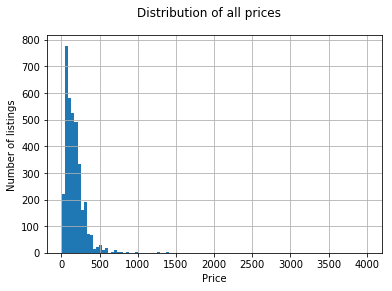

In [41]:
listings_df_clean['price'].hist(bins=100);
plt.suptitle("Distribution of all prices");   
plt.xlabel('Price');
plt.ylabel('Number of listings');

For better clarity I will consider only those under 1200 Dollar, otherwise the few outliers make it hard to see.

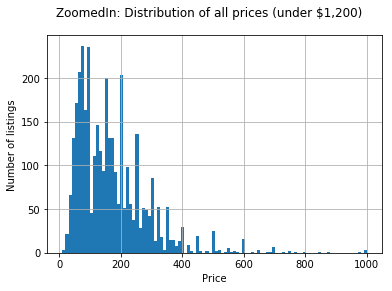

In [42]:
listings_df_clean[listings_df_clean['price'] <1200].price.hist(bins=100);
plt.suptitle("ZoomedIn: Distribution of all prices (under $1,200)");   
plt.xlabel('Price');
plt.ylabel('Number of listings');

Now I want to calculate price distribution per room type.

For shared room:

count     79.000000
mean      93.177215
std      109.364922
min       20.000000
25%       45.000000
50%       60.000000
75%       99.000000
max      750.000000
Name: price, dtype: float64

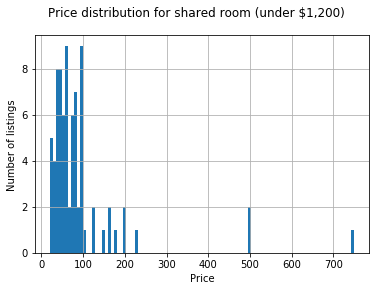

In [43]:
listings_df_clean[(listings_df_clean['price'] < 1200) & (listings_df_clean['shared_room'] == 1)]['price'].hist(bins=100)
plt.suptitle("Price distribution for shared room (under $1,200)")
plt.xlabel('Price')
plt.ylabel('Number of listings')
listings_df_clean[listings_df_clean['shared_room'] == 1]['price'].describe()

For private room:

count    1354.000000
mean       95.839734
std        85.277887
min        20.000000
25%        62.000000
50%        79.000000
75%       100.000000
max      1400.000000
Name: price, dtype: float64

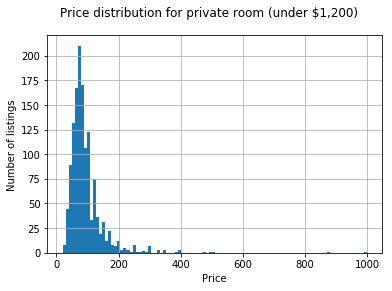

In [44]:
listings_df_clean[(listings_df_clean['price'] <1200) & (listings_df_clean['private_room'] == 1)]['price'].hist(bins=100)
plt.suptitle("Price distribution for private room (under $1,200)")
plt.xlabel('Price')
plt.ylabel('Number of listings')
listings_df_clean[listings_df_clean['private_room'] == 1]['price'].describe()

For entire apartment:

count    2111.000000
mean      227.842729
std       158.313202
min        11.000000
25%       150.000000
50%       199.000000
75%       270.000000
max      4000.000000
Name: price, dtype: float64

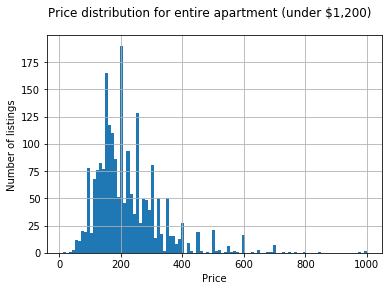

In [45]:
listings_df_clean[(listings_df_clean['price'] <1200) & (listings_df_clean['entire_home_apt'] == 1)]['price'].hist(bins=100)
plt.suptitle("Price distribution for entire apartment (under $1,200)")
plt.xlabel('Price')
plt.ylabel('Number of listings')
listings_df_clean[listings_df_clean['entire_home_apt'] == 1]['price'].describe()

## Question 2: How is the price changing over time (count in months) and what are the top 5 average most expensive zipcodes all time?

In [46]:
calendar_df_clean['year-month'].max()

'2017-09'

Text(0.5, 1.0, 'Price average each month')

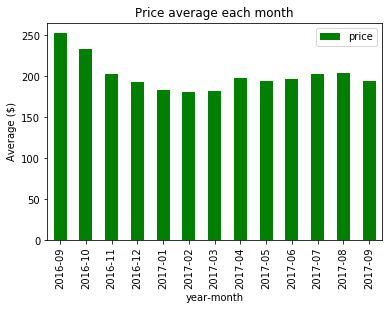

In [47]:
price_per_month_df = pd.DataFrame(calendar_df_clean.groupby('year-month').mean()).reset_index()
price_per_month_df.plot.bar(x='year-month',y='price',color='green')
plt.ylabel('Average ($)')
plt.title("Price average each month")

Quick check on the top 5 most expensive zip codes.
Firstly, considering individual value price.
Then, after averaging per zipcode, all prices, all time.

In [48]:
auxiliary_df_zipcode_stats = listings_df_clean.groupby('zipcode')['price'].describe() #.count()
top_5_expensive_individual = auxiliary_df_zipcode_stats.sort_values(['max'], ascending = False)['max'].head(5)
top_5_expensive_mean = auxiliary_df_zipcode_stats.sort_values(['mean'], ascending = False)['mean'].head(5)

top_5_expensive_individual

zipcode
2215    4000.0
2210    3000.0
2118    1400.0
2115    1372.0
2114    1345.0
Name: max, dtype: float64

In [49]:
print("Those are top 5 most expensive zipcodes on average, all time:")
top_5_expensive_mean


Those are top 5 most expensive zipcodes on average, all time:


zipcode
2210    313.440000
2110    281.083333
2142    270.000000
2111    253.535354
2109    238.941176
Name: mean, dtype: float64

## Question 3: What is the distribution of demand over the entire time, per month?

Here I calculate the demand by counting reviews of the users, over the whole time. I accumulate the values with resolution of a month, for better visualization.


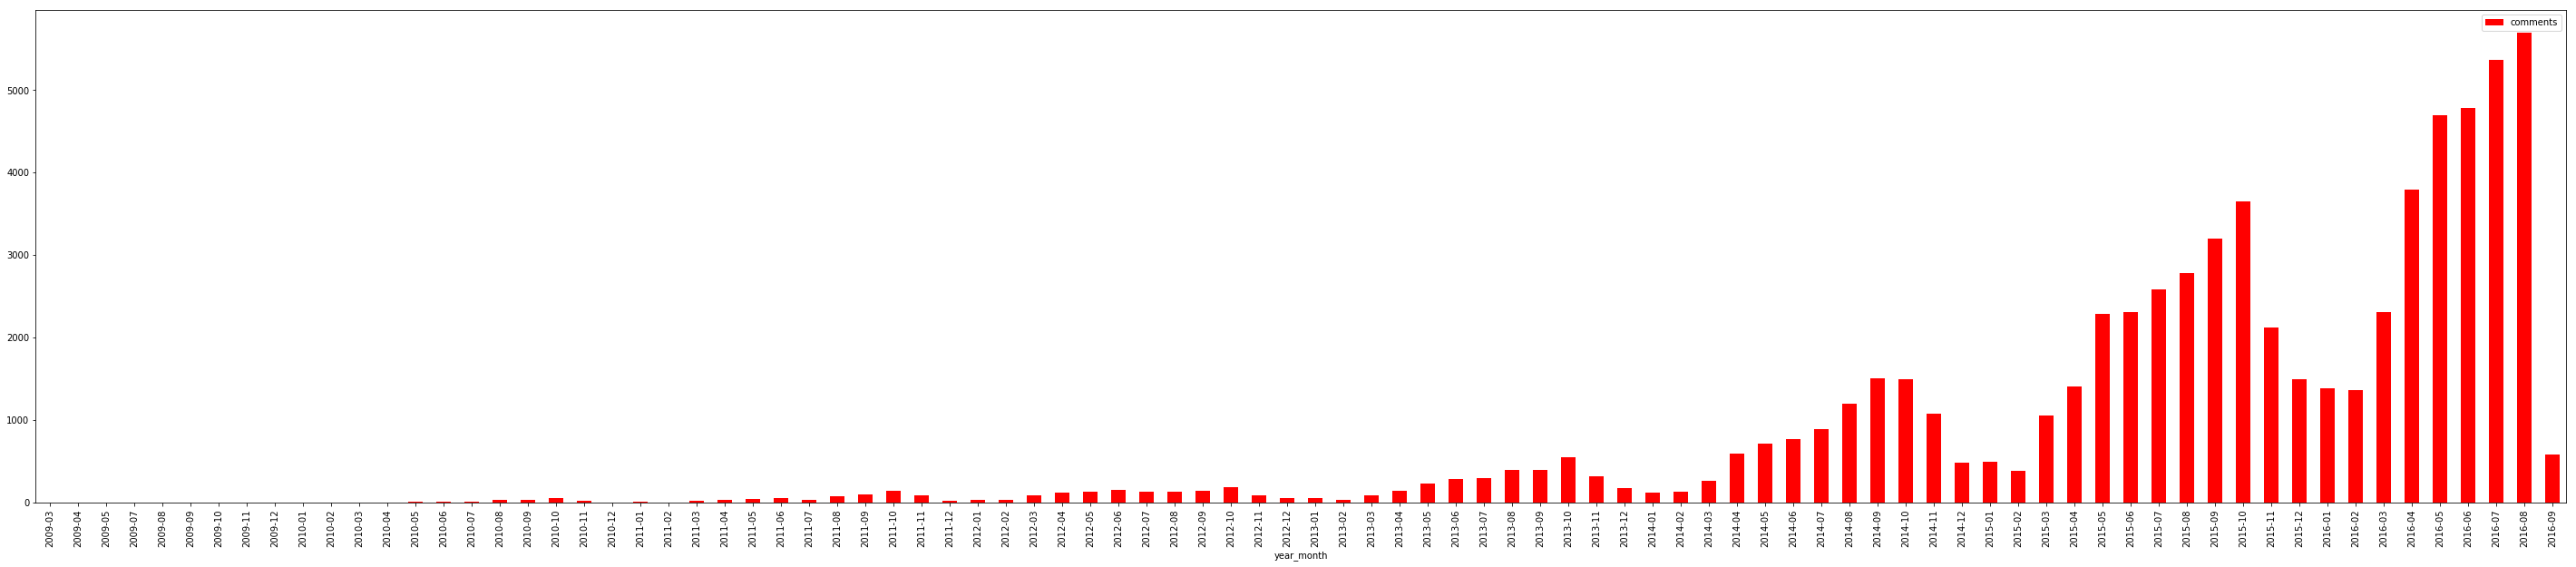

In [50]:
reviews_df_clean['year-month'] = reviews_df_clean['date'].apply(lambda x: '-'.join(x.split('-')[:2]))
reviews_df_clean.drop(columns = ['date'], inplace = True)

comments_per_month_df = pd.DataFrame(reviews_df_clean.groupby('year-month')['id'].count()).reset_index()
comments_per_month_df.columns = ['year_month','comments']
comments_per_month_df.plot.bar(x='year_month',y='comments',color='red',figsize=(50,10));

In [51]:
comments_per_month_df['year_month'].min()

'2009-03'

In [52]:
comments_per_month_df['year_month'].max()

'2016-09'

# Summary

I have a few observations based on this analysis.
* Firstly, some conclusions from the distribution of room prices per room type:
    - shared room:
        - average 93.18 USD, with 75% being below 99 USD. Minimum price was 20 USD.
    - private room:
        - average 95.83 USD, with 75% being below 100 USD. Minimum price was 20 USD.
    - entire apartment:
        - average 227.84 USD, with 75% being below 270 USD. Minimum price was 1 USD!
* Secondly, the price between Sep. 2016 and Sep. 2017, for the data available in the calendar, did not change practically at all on average. This does not consider how individual areas fluctuated and what was the spread and if that changed, but on average this is the result. I would assume that exactly the fact of some areas becoming more and some less expensive could have averaged itself out.
* Thirdly, clearly we can see a pattern that demand is increasing, drastically over the last years. The data dates back to 2009 the earliest (maybe hard to read in the plot, I provided read out from the dataframe), however the drastic increase is observed in the last 4 years, more and more. This is also seasonal, usually increasing up to september - october, peaking and dropping in winter.